# At this notebook, I have tried to discover a pattern of Google searches of diet in Ukraine 
Some periodicity is observed, connected at least to New Year holidays


Weekly data is taken from https://trends.google.ru/trends/explore?date=today%205-y&geo=UA&q=%D0%B4%D0%B8%D0%B5%D1%82%D0%B0

In [70]:
import pandas as pd
diet = pd.read_csv('Google_diet_Ukraine.csv')
diet['Week'] = pd.to_datetime(diet['Week'])
diet.set_index('Week', inplace=True)

In [119]:
diet.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 260 entries, 2013-06-16 to 2018-06-03
Data columns (total 1 columns):
Searches    260 non-null int64
dtypes: int64(1)
memory usage: 4.1 KB


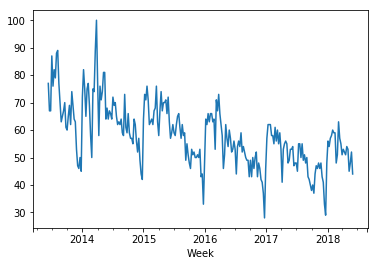

In [120]:
import matplotlib.pyplot as plt
%matplotlib inline
diet.loc[:,'Searches'].plot()

In [85]:
from statsmodels.tsa.stattools import adfuller
# Run the ADF test on the series and print out the results
results = adfuller(diet['Searches'])
print(results)

# Just print out the p-value
print('The p-value of the test on prices is: ' + str(results[1]))

(-2.9452406185614506, 0.040334409159480576, 6, 253, {'1%': -3.4564641849494113, '5%': -2.873032730098417, '10%': -2.572894516864816}, 1610.7484788921536)
The p-value of the test on prices is: 0.040334409159480576


With the ADF test, the "null hypothesis" (the hypothesis that we either reject or fail to reject) is that the series follows a random walk. Therefore, a low p-value (say less than 5%) means we can reject the null hypothesis that the series is a random walk.

A random walk is an example of nonstationary series, that can't be parametrized in order to get understanding of the series and it's further forecasting.

In our case series is stationary with 95% probability. Anyway, we know about seasonal effects. So diff of data would lead to better p-value:

The p-value of the test on prices is: 1.755513522618631e-14


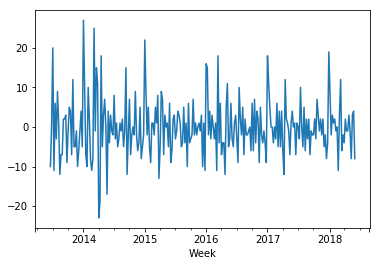

In [126]:
# Run the ADF test on the series and print out the results
diet_diff = diet.diff()
diet_diff.dropna(inplace=True)
results = adfuller(diet_diff['Searches'])

# Just print out the p-value
print('The p-value of the test on prices is: ' + str(results[1]))
diet_diff.loc[:,'Searches'].plot()

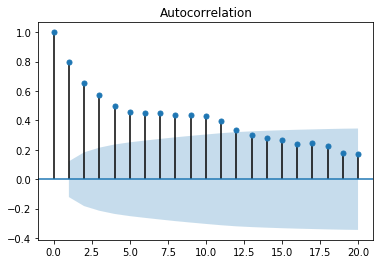

In [121]:
from statsmodels.graphics.tsaplots import plot_acf

# Plot the acf function
plot_acf(diet['Searches'], alpha = 0.05, lags=20)
plt.show()

So significant autocorrelation is clearly observed for first 10-12 weeks.


Let's differentiate data in order to discover stationarity

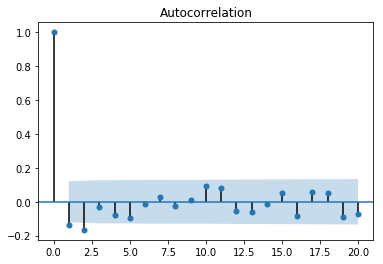

In [127]:
plot_acf(diet_diff['Searches'], alpha = 0.05, lags=20)
plt.show()

We can see significant autocorrelation only for first 2 weeks, maybe AR(2) would fit data_diff

In [128]:
# Import the ARMA module from statsmodels
from statsmodels.tsa.arima_model import ARMA

# Fit an AR(2) model to the first simulated data
mod = ARMA(diet_diff['Searches'].astype(float), order=(2,0))
res = mod.fit()

# Print out summary information on the fit
print(res.summary())

# Print out the estimate for the constant and for phi
print(" the estimate of phi (and the constant) are:")
print(res.params)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


                              ARMA Model Results                              
Dep. Variable:               Searches   No. Observations:                  259
Model:                     ARMA(2, 0)   Log Likelihood                -867.217
Method:                       css-mle   S.D. of innovations              6.884
Date:                Tue, 12 Jun 2018   AIC                           1742.433
Time:                        12:44:05   BIC                           1756.661
Sample:                    06-23-2013   HQIC                          1748.153
                         - 06-03-2018                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.1117      0.316     -0.353      0.724      -0.732       0.508
ar.L1.Searches    -0.1646      0.061     -2.686      0.008      -0.285      -0.044
ar.L2.Searches    -0.1895      0.061

Let's check the optimal order of regression according to the partial autocorrelation function

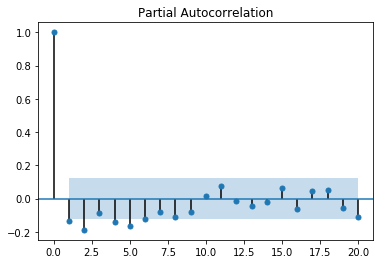

In [129]:
# Import the modules for simulating data and for plotting the PACF
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(diet_diff['Searches'].astype(float), lags=20)
plt.show()


According to PACF delay of 1,2,4,5 weak matters. Let's also look at Baies informational criteria.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


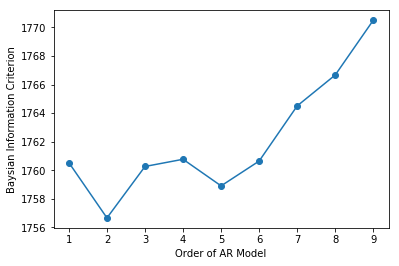

In [132]:
# Import the module for estimating an ARMA model
from statsmodels.tsa.arima_model import ARMA
import numpy as np
# Fit the data to an AR(p) for p = 0,...,6 , and save the BIC
BIC = np.zeros(10)
for p in range(10):
    mod = ARMA(diet_diff['Searches'].astype(float), order=(p,0))
    res = mod.fit()
# Save BIC for AR(p)    
    BIC[p] = res.bic
    
# Plot the BIC as a function of p
plt.plot(range(1,10), BIC[1:10], marker='o')
plt.xlabel('Order of AR Model')
plt.ylabel('Baysian Information Criterion')
plt.show()

According to BIC best AR parameter is 2.

Let's also look at moving average part and discover it further with AIC criteria:

In [134]:
# Import the module for estimating an ARMA model
from statsmodels.tsa.arima_model import ARMA

for i in range(4):
    for j in range(3):
        # Fit the data to an AR(1) model and print AIC:
        mod = ARMA(diet_diff['Searches'].astype(float), order=(i,j))
        res = mod.fit()
        print("The AIC for an AR " + str(i) + " and MA " + str(j)+ "  is: ", res.aic)


The AIC for an AR 0 and MA 0  is:  1752.8392947805658
The AIC for an AR 0 and MA 1  is:  1746.634786289455


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


The AIC for an AR 0 and MA 2  is:  1729.910754901206
The AIC for an AR 1 and MA 0  is:  1749.8578919009217
The AIC for an AR 1 and MA 1  is:  1713.0884131658845
The AIC for an AR 1 and MA 2  is:  1714.7696006109722
The AIC for an AR 2 and MA 0  is:  1742.433233456542
The AIC for an AR 2 and MA 1  is:  1714.8158036847212
The AIC for an AR 2 and MA 2  is:  1712.7141085096487
The AIC for an AR 3 and MA 0  is:  1742.4801422083674
The AIC for an AR 3 and MA 1  is:  1716.2493002591937
The AIC for an AR 3 and MA 2  is:  1714.6929994187517


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


So best parameters for diet_diff is ARMA(2,2), so for diet it is ARIMA(2,1,2):

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


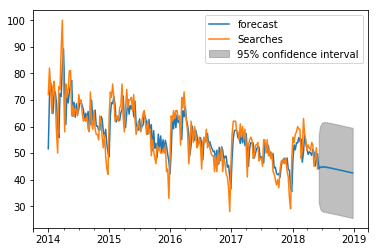

In [137]:
# Import the ARIMA module from statsmodels
from statsmodels.tsa.arima_model import ARIMA

# Forecast interest rates using an AR(1) model
mod = ARIMA(diet['Searches'].astype(float), order=(2,1,2))
res = mod.fit()

# Plot the original series and the forecasted series
res.plot_predict(start='2014-01-05', end='2019-01-01')
plt.show()